In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col

In [32]:
plt.style.use('ggplot')

In [11]:
with open('all_many_bubbles_output.json', 'r') as f:
    bubble_data = json.loads(f.read())

# Analyse the distributional consequences of various bubble episodes

Hypotheses:

### General effects
* a boom increases wealth inequelity because it can disproportionally benefit the rich
* a bust might decrease wealth inequality because it reverses this effect
* a bust-boom might decrease wealth inequality because it levels the playing field? 

### Which types of traders benefit:


In [12]:
runs = len(bubble_data)
runs

8

In [5]:
bubble_types = []
bubble_prices = []
wealth_starts = []
wealth_ends = []
ginis_ot = []
palmas_ot = []
twtws_ot = []
for r in range(runs):
    bubble_types += bubble_data[r][0]#bubble_data[0][0] + bubble_data[1][0]
    bubble_prices += bubble_data[r][1]
    wealth_starts += bubble_data[r][2]
    wealth_ends += bubble_data[r][3]
    ginis_ot += bubble_data[r][4]
    palmas_ot += bubble_data[r][5]
    twtws_ot += bubble_data[r][6]

In [6]:
unique_bubble_types = list(set(bubble_types))
unique_bubble_types

[u'boom-bust', u'None', u'bust-boom', u'boom', u'bust']

### Calculate gini, palma, twtws differences 

In [7]:
ginis_ot_dif = [g[-1] - g[0] for g in ginis_ot]
palmas_ot_dif = [g[-1] - g[0] for g in palmas_ot]
twtws_ot_dif = [g[-1] - g[0] for g in twtws_ot]

### Calculate bubble magnitude and lenght

In [16]:
bubble_lenght = [len(b) for b in bubble_prices]

In [27]:
# if boom or bust, magnitude is price difference 
bubble_magnitude = []
for idx, b_type in enumerate(bubble_types):
    if b_type in ['boom', 'bust']:
        bubble_magnitude.append(bubble_prices[idx][-1] - bubble_prices[idx][0])
    elif b_type in ['boom-bust', 'bust-boom']:
        bubble_magnitude.append(np.mean(bubble_prices[idx]) - bubble_prices[idx][0])
    else:
        #print(b_type)
        bubble_magnitude.append(pd.Series(bubble_prices[idx]).std())

In [28]:
bubble_df = pd.DataFrame({'bubble_type': bubble_types, 'magnitude': bubble_magnitude, 'lenght': bubble_lenght, 
              'gini_diff': ginis_ot_dif, 'palma_diff': palmas_ot_dif, 'twtw_diff': twtws_ot_dif})

In [29]:
bubble_df['const'] = 1

In [30]:
bubble_df.head()

,bubble_type,gini_diff,lenght,magnitude,palma_diff,twtw_diff,const
0,None,0.002487,60,0.944637,0.052138,0.185575,1
1,None,0.000906,41,0.341087,0.018427,0.062179,1
2,None,0.008575,130,1.721101,0.197431,0.709357,1
3,None,0.004254,14,1.997351,0.101211,0.324108,1
4,boom-bust,0.002487,60,1.679327,0.052138,0.185575,1


In [31]:
bubble_groups = bubble_df.groupby('bubble_type')

In [32]:
boom_busts = bubble_df.query('bubble_type == "boom-bust"')
bust_booms = bubble_df.query('bubble_type == "bust-boom"')
busts = bubble_df.query('bubble_type == "bust"')
booms = bubble_df.query('bubble_type == "boom"')
no_bubble = bubble_df.query('bubble_type == "None"')

# Inequality analysis: 

Inspired by: https://lectures.quantecon.org/py/ols.html

For every bubble type: 

Y = gini_diff, palma_diff, twtw_diff

X = magnitude, lenght

Text(0,0.5,'20-20 diff')

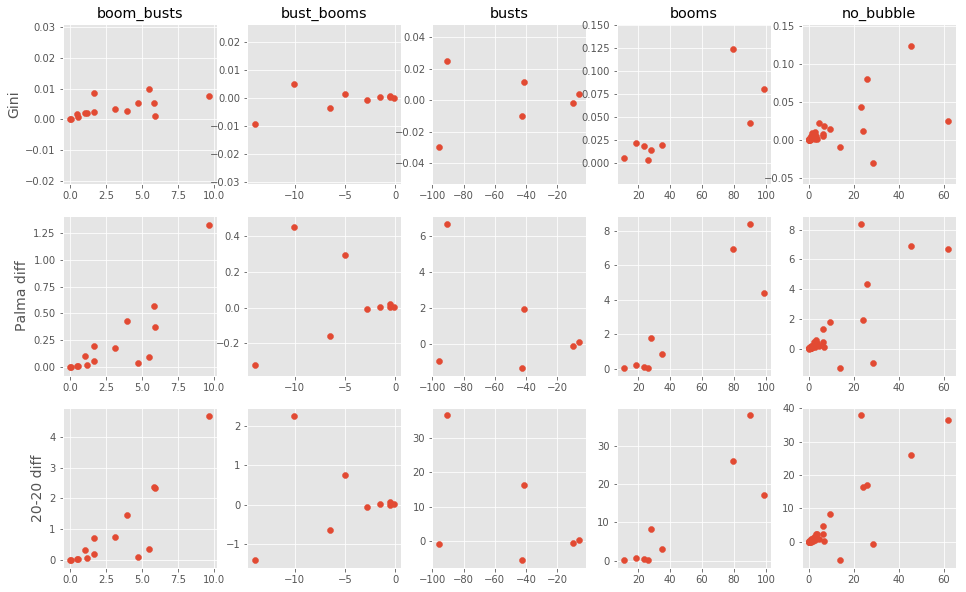

In [35]:
fig, ((ax1, ax2, ax3, ax4, axn1), (ax5, ax6, ax7, ax8, axn2), (ax9, ax10, ax11, ax12, axn3)) = plt.subplots(3, 5, figsize=[16,10])

ax1.scatter(boom_busts['magnitude'], boom_busts['gini_diff'])
ax2.scatter(bust_booms['magnitude'], bust_booms['gini_diff'])
ax3.scatter(busts['magnitude'], busts['gini_diff'])
ax4.scatter(booms['magnitude'], booms['gini_diff'])
axn1.scatter(no_bubble['magnitude'], no_bubble['gini_diff'])

ax5.scatter(boom_busts['magnitude'], boom_busts['palma_diff'])
ax6.scatter(bust_booms['magnitude'], bust_booms['palma_diff'])
ax7.scatter(busts['magnitude'], busts['palma_diff'])
ax8.scatter(booms['magnitude'], booms['palma_diff'])
axn2.scatter(no_bubble['magnitude'], no_bubble['palma_diff'])

ax9.scatter(boom_busts['magnitude'], boom_busts['twtw_diff'])
ax10.scatter(bust_booms['magnitude'], bust_booms['twtw_diff'])
ax11.scatter(busts['magnitude'], busts['twtw_diff'])
ax12.scatter(booms['magnitude'], booms['twtw_diff'])
axn3.scatter(no_bubble['magnitude'], no_bubble['twtw_diff'])

ax1.set_title('boom_busts')
ax2.set_title('bust_booms')
ax3.set_title('busts')
ax4.set_title('booms')
axn1.set_title('no_bubble')

ax1.set_ylabel('Gini', fontsize=14)
ax5.set_ylabel('Palma diff', fontsize=14)
ax9.set_ylabel('20-20 diff', fontsize=14)

### Gini regression

In [17]:
gini_reg1 = sm.OLS(endog=boom_busts['gini_diff'], exog=boom_busts[['const', 'lenght', 'magnitude']], missing='drop')
gini_reg2 = sm.OLS(endog=bust_booms['gini_diff'], exog=bust_booms[['const', 'lenght', 'magnitude']], missing='drop')
gini_reg3 = sm.OLS(endog=busts['gini_diff'], exog=busts[['const', 'lenght', 'magnitude']], missing='drop')
gini_reg4 = sm.OLS(endog=booms['gini_diff'], exog=booms[['const', 'lenght', 'magnitude']], missing='drop')

gini_res1 = gini_reg1.fit()
gini_res2 = gini_reg2.fit()
gini_res3 = gini_reg3.fit()
gini_res4 = gini_reg4.fit()

In [18]:
info_dict={'R-squared' : lambda x: "{}".format(x.rsquared), 
           'No. observations' : lambda x: "{}".format(int(x.nobs))}

results_table = summary_col(results=[gini_res1,gini_res2,gini_res3, gini_res4],
                            float_format='%0.4f',
                            stars = True,
                            model_names=['boom-bust',
                                         'bust-boom',
                                         'busts', 'booms'],
                            info_dict=info_dict,
                            regressor_order=['const', 'lenght', 'magnitude'])

results_table.add_title('Table 2 - OLS Regressions')

print(results_table)

                          Table 2 - OLS Regressions
                   boom-bust      bust-boom        busts          booms     
----------------------------------------------------------------------------
const            0.0003         0.0023         -0.0032        -0.0182       
                 (0.0009)       (0.0024)       (0.0127)       (0.0220)      
lenght           0.0000***      -0.0000        0.0000         0.0000        
                 (0.0000)       (0.0000)       (0.0000)       (0.0001)      
magnitude        0.0005**       0.0004         0.0001         0.0010**      
                 (0.0002)       (0.0003)       (0.0002)       (0.0003)      
No. observations 15             9              6              9             
R-squared        0.652477120891 0.279933491699 0.476151827545 0.663290587399
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


### Palma regression

In [19]:
palma_reg1 = sm.OLS(endog=boom_busts['palma_diff'], exog=boom_busts[['const', 'lenght', 'magnitude']], missing='drop').fit()
palma_reg2 = sm.OLS(endog=bust_booms['palma_diff'], exog=bust_booms[['const', 'lenght', 'magnitude']], missing='drop').fit()
palma_reg3 = sm.OLS(endog=busts['palma_diff'], exog=busts[['const', 'lenght', 'magnitude']], missing='drop').fit()
palma_reg4 = sm.OLS(endog=booms['palma_diff'], exog=booms[['const', 'lenght', 'magnitude']], missing='drop').fit()

In [20]:
info_dict={'R-squared' : lambda x: "{}".format(x.rsquared), 
           'No. observations' : lambda x: "{}".format(int(x.nobs))}

results_table = summary_col(results=[palma_reg1,palma_reg2,palma_reg3, palma_reg4],
                            float_format='%0.4f',
                            stars = True,
                            model_names=['boom-bust',
                                         'bust-boom',
                                         'busts', 'booms'],
                            info_dict=info_dict,
                            regressor_order=['const', 'lenght', 'magnitude'])

results_table.add_title('Table 2 - OLS Regressions')

print(results_table)

                         Table 2 - OLS Regressions
                   boom-bust      bust-boom        busts         booms     
---------------------------------------------------------------------------
const            0.0114         0.1532         -1.2895       -1.1544       
                 (0.0640)       (0.1484)       (1.9919)      (1.3328)      
lenght           -0.0015***     -0.0011        0.0054        -0.0012       
                 (0.0004)       (0.0010)       (0.0040)      (0.0039)      
magnitude        0.1157***      0.0077         -0.0243       0.0844***     
                 (0.0145)       (0.0177)       (0.0326)      (0.0186)      
No. observations 15             9              6             9             
R-squared        0.847148132307 0.165062847821 0.48614176175 0.810148842308
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


## 20-20 regression

In [21]:
twtw_reg1 = sm.OLS(endog=boom_busts['twtw_diff'], exog=boom_busts[['const', 'lenght', 'magnitude']], missing='drop').fit()
twtw_reg2 = sm.OLS(endog=bust_booms['twtw_diff'], exog=bust_booms[['const', 'lenght', 'magnitude']], missing='drop').fit()
twtw_reg3 = sm.OLS(endog=busts['twtw_diff'], exog=busts[['const', 'lenght', 'magnitude']], missing='drop').fit()
twtw_reg4 = sm.OLS(endog=booms['twtw_diff'], exog=booms[['const', 'lenght', 'magnitude']], missing='drop').fit()

In [22]:
info_dict={'R-squared' : lambda x: "{}".format(x.rsquared), 
           'No. observations' : lambda x: "{}".format(int(x.nobs))}

results_table = summary_col(results=[twtw_reg1,twtw_reg2,twtw_reg3, twtw_reg4],
                            float_format='%0.4f',
                            stars = True,
                            model_names=['boom-bust',
                                         'bust-boom',
                                         'busts', 'booms'],
                            info_dict=info_dict,
                            regressor_order=['const', 'lenght', 'magnitude'])

results_table.add_title('Table 2 - OLS Regressions')

print(results_table)

                          Table 2 - OLS Regressions
                   boom-bust      bust-boom        busts          booms     
----------------------------------------------------------------------------
const            0.0760         0.5570         -6.7403        -4.1325       
                 (0.1811)       (0.6662)       (8.9491)       (6.1396)      
lenght           -0.0061***     -0.0043        0.0332         -0.0078       
                 (0.0012)       (0.0046)       (0.0180)       (0.0181)      
magnitude        0.4501***      0.0232         -0.1507        0.3438***     
                 (0.0410)       (0.0796)       (0.1465)       (0.0857)      
No. observations 15             9              6              9             
R-squared        0.913173272792 0.125771615668 0.639057327357 0.775406156139
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


# Analyse shock effects

After the shock, measure the first bubble. Record it's type, lenght, and impact on various measures of inequality.

In [3]:
with open('shocked_bubbles_output.json', 'r') as f:
    shock_data = json.loads(f.read())

In [6]:
runs = len(shock_data)
runs

12

In [5]:
bubble_types = []
bubble_prices = []
wealth_starts = []
wealth_ends = []
ginis_ot = []
palmas_ot = []
twtws_ot = []
bubble_prices_ns = []
wealth_ends_ns = []
ginis_ot_ns = []
palmas_ot_ns = []
twtws_ot_ns = []

for r in range(runs):
    bubble_types += shock_data[r][0]#bubble_data[0][0] + bubble_data[1][0]
    bubble_prices += shock_data[r][1]
    wealth_starts += shock_data[r][2]
    wealth_ends += shock_data[r][3]
    ginis_ot += shock_data[r][4]
    palmas_ot += shock_data[r][5]
    twtws_ot += shock_data[r][6]
    bubble_prices_ns += shock_data[r][7]
    wealth_ends_ns += shock_data[r][8]
    ginis_ot_ns += shock_data[r][9]
    palmas_ot_ns += shock_data[r][10]
    twtws_ot_ns += shock_data[r][11]

IndexError: list index out of range

In [63]:
bubble_types

[u'boom',
 u'boom',
 u'boom',
 u'boom',
 u'bust-boom',
 u'boom',
 u'boom',
 u'boom',
 u'bust',
 u'bust-boom',
 u'bust',
 u'boom']

In [64]:
unique_bubble_types = list(set(bubble_types))
unique_bubble_types

[u'bust-boom', u'boom', u'bust']

## Effect of bubble on inequality vis à vis no bubble 

In [65]:
effect_on_gini = [bub[-1] - no_bub[-1] for bub, no_bub in zip(ginis_ot, ginis_ot_ns)]
effect_on_palma = [bub[-1] - no_bub[-1] for bub, no_bub in zip(palmas_ot, palmas_ot_ns)]
effect_on_twtws = [bub[-1] - no_bub[-1] for bub, no_bub in zip(twtws_ot, twtws_ot_ns)]

In [66]:
boom_bust_effect_gini = np.array(effect_on_gini)[np.array(bubble_types) == 'boom-bust']
boom_bust_effect_palma = np.array(effect_on_palma)[np.array(bubble_types) == 'boom-bust']
boom_bust_effect_twtws = np.array(effect_on_twtws)[np.array(bubble_types) == 'boom-bust']

bust_boom_effect_gini = np.array(effect_on_gini)[np.array(bubble_types) == 'bust-boom']
bust_boom_effect_palma = np.array(effect_on_palma)[np.array(bubble_types) == 'bust-boom']
bust_boom_effect_twtws = np.array(effect_on_twtws)[np.array(bubble_types) == 'bust-boom']

In [67]:
bust_effect_gini = np.array(effect_on_gini)[np.array(bubble_types) == 'bust']
bust_effect_palma = np.array(effect_on_palma)[np.array(bubble_types) == 'bust']
bust_effect_twtws = np.array(effect_on_twtws)[np.array(bubble_types) == 'bust']

boom_effect_gini = np.array(effect_on_gini)[np.array(bubble_types) == 'boom']
boom_effect_palma = np.array(effect_on_palma)[np.array(bubble_types) == 'boom']
boom_effect_twtws = np.array(effect_on_twtws)[np.array(bubble_types) == 'boom']

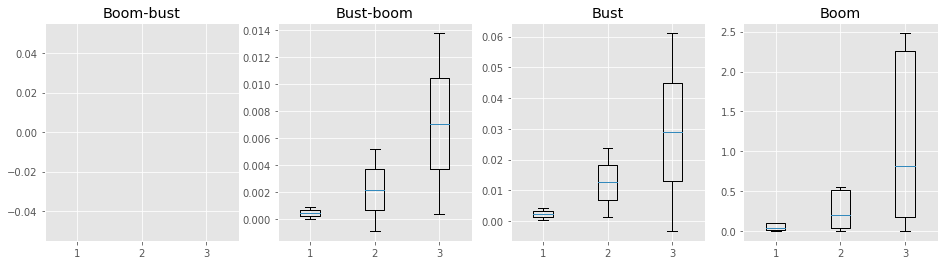

In [68]:
fig1, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16,4))

ax1.set_title('Gini') 
ax1.boxplot([boom_bust_effect_gini, bust_boom_effect_gini, bust_effect_gini, boom_effect_gini], showfliers=False)

ax2.set_title('Palma')
ax2.boxplot([boom_bust_effect_palma, bust_boom_effect_palma, bust_effect_palma, boom_effect_palma], showfliers=False)

ax3.set_title('Twenty-twenty')
ax3.boxplot([boom_bust_effect_twtws, bust_boom_effect_twtws, bust_effect_twtws, boom_effect_twtws], showfliers=False)


fig1.savefig('shock_effects_bubbles.png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

### Calculate bubble magnitude and lenght

In [18]:
bubble_lenght = [len(b) for b in bubble_prices]

In [19]:
# if boom or bust, magnitude is price difference 
bubble_magnitude = []
for idx, b_type in enumerate(bubble_types):
    if b_type in ['boom', 'bust']:
        bubble_magnitude.append(bubble_prices[idx][-1] - bubble_prices[idx][0])
    elif b_type in ['boom-bust', 'bust-boom']:
        bubble_magnitude.append(np.mean(bubble_prices[idx]) - bubble_prices[idx][0])
    else:
        #print(b_type)
        bubble_magnitude.append(pd.Series(bubble_prices[idx]).std())

In [20]:
bubble_df = pd.DataFrame({'bubble_type': bubble_types, 'magnitude': bubble_magnitude, 'lenght': bubble_lenght, 
              'gini_diff': ginis_ot_dif, 'palma_diff': palmas_ot_dif, 'twtw_diff': twtws_ot_dif})

In [21]:
bubble_df['const'] = 1

In [23]:
bubble_df.tail()

,bubble_type,gini_diff,lenght,magnitude,palma_diff,twtw_diff,const
35,None,0.000608,206,0.969779,0.003325,0.006737,1
36,None,0.000334,92,0.449900,0.001548,0.003716,1
37,bust-boom,0.000608,206,-1.497770,0.003325,0.006737,1
38,bust-boom,0.000334,92,-0.558405,0.001548,0.003716,1
39,boom,0.003469,389,26.213828,0.020622,0.076672,1


In [24]:
bubble_groups = bubble_df.groupby('bubble_type')

In [25]:
boom_busts = bubble_df.query('bubble_type == "boom-bust"')
bust_booms = bubble_df.query('bubble_type == "bust-boom"')
busts = bubble_df.query('bubble_type == "bust"')
booms = bubble_df.query('bubble_type == "boom"')
no_bubble = bubble_df.query('bubble_type == "None"')

# Inequality analysis: 

After the shock, measure the first bubble. Record it's type, lenght, and impact on various measures of inequality.

Text(0,0.5,'20-20 diff')

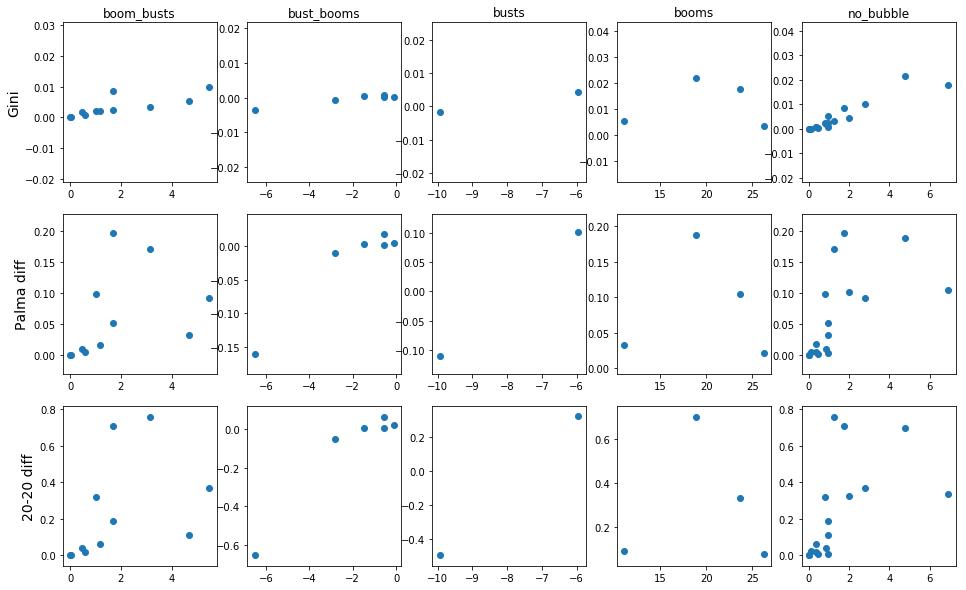

In [28]:
fig, ((ax1, ax2, ax3, ax4, axn1), (ax5, ax6, ax7, ax8, axn2), (ax9, ax10, ax11, ax12, axn3)) = plt.subplots(3, 5, figsize=[16,10])

ax1.scatter(boom_busts['magnitude'], boom_busts['gini_diff'])
ax2.scatter(bust_booms['magnitude'], bust_booms['gini_diff'])
ax3.scatter(busts['magnitude'], busts['gini_diff'])
ax4.scatter(booms['magnitude'], booms['gini_diff'])
axn1.scatter(no_bubble['magnitude'], no_bubble['gini_diff'])

ax5.scatter(boom_busts['magnitude'], boom_busts['palma_diff'])
ax6.scatter(bust_booms['magnitude'], bust_booms['palma_diff'])
ax7.scatter(busts['magnitude'], busts['palma_diff'])
ax8.scatter(booms['magnitude'], booms['palma_diff'])
axn2.scatter(no_bubble['magnitude'], no_bubble['palma_diff'])

ax9.scatter(boom_busts['magnitude'], boom_busts['twtw_diff'])
ax10.scatter(bust_booms['magnitude'], bust_booms['twtw_diff'])
ax11.scatter(busts['magnitude'], busts['twtw_diff'])
ax12.scatter(booms['magnitude'], booms['twtw_diff'])
axn3.scatter(no_bubble['magnitude'], no_bubble['twtw_diff'])

ax1.set_title('boom_busts')
ax2.set_title('bust_booms')
ax3.set_title('busts')
ax4.set_title('booms')
axn1.set_title('no_bubble')

ax1.set_ylabel('Gini', fontsize=14)
ax5.set_ylabel('Palma diff', fontsize=14)
ax9.set_ylabel('20-20 diff', fontsize=14)

# Understand why shock doesn't work

In [1]:
import numpy as np
import pandas as pd
import math
import json
from distribution_model import *
from init_objects import *
from functions.helpers import organise_data
from functions.inequality import gini

In [7]:
seed = 0
BURN_IN = 200
SHOCK = 12000.0#8000.0
SHOCK_PERIOD = 400

params = {"spread_max": 0.004087, "fundamental_value": 166, "fundamentalist_horizon_multiplier": 0.73132061,
          "n_traders": 500, "w_fundamentalists": 37.20189844, "base_risk_aversion": 11.65898537,
          "mutation_probability": 0.30623129, "init_stocks": 50, "trader_sample_size": 19, "ticks": 1000,
          "std_fundamental": 0.0530163128919286, "std_noise": 0.29985649, "trades_per_tick": 5,
          "average_learning_ability": 0.57451773, "w_momentum": 0.01, "horizon": 200, "w_random": 1.0}

# simulate model once
obs = []
# run model with parameters
print('Simulate once')
traders, orderbook = init_objects_distr(params, seed)
traders, orderbook = pb_distr_model_shock(traders, orderbook, params, SHOCK, SHOCK_PERIOD, seed)
obs.append(orderbook)

# store simulated stylized facts
mc_prices, mc_returns, mc_autocorr_returns, mc_autocorr_abs_returns, mc_volatility, mc_volume, mc_fundamentals = organise_data(
    obs, burn_in_period=BURN_IN)

y = pd.Series(mc_prices[0][:-1] / mc_fundamentals[0])

Simulate once
('Apply shock in simulation ', 0)


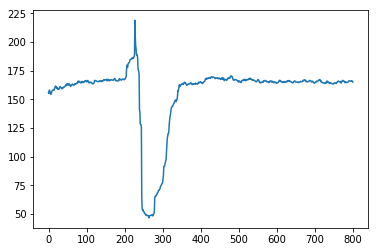

In [8]:
mc_prices[0][:-1].plot()

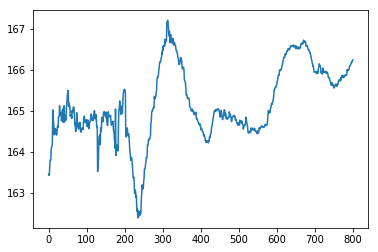

In [4]:
mc_prices[0][:-1].plot()